In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from scipy.stats import uniform # For RandomizedSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [3]:
try:
    df = pd.read_csv('train.csv')
except FileNotFoundError:
    print("Error: train.csv not found. Please make sure the file is in the same directory.")
    exit()

In [4]:
df_processed = df.copy()

In [5]:
df_processed.drop('Cabin',axis=1,inplace=True)
df_processed['Age'].fillna(df_processed['Age'].median(), inplace=True)
most_freq_embarked=df_processed['Embarked'].mode()[0]
df_processed['Embarked'].fillna(most_freq_embarked, inplace=True)

In [6]:
df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1
df_processed['IsAlone'] = 0
df_processed.loc[df_processed['FamilySize'] == 1, 'IsAlone'] = 1
df_processed['Title'] = df_processed['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
title_mapping = {
    "Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master",
    "Dr": "Rare", "Rev": "Rare", "Col": "Rare", "Major": "Rare", "Mlle": "Rare",
    "Countess": "Rare", "Ms": "Rare", "Lady": "Rare", "Jonkheer": "Rare",
    "Don": "Rare", "Dona": "Rare", "Mme": "Rare", "Capt": "Rare", "Sir": "Rare"
}
df_processed['Title'] = df_processed['Title'].map(title_mapping)

In [7]:
df_processed.drop(['Name', 'Ticket', 'PassengerId', 'SibSp', 'Parch'], axis=1, inplace=True)


In [8]:
bins = [0, 12, 18, 60, np.inf]
labels = ['Child', 'Teenager', 'Adult', 'Elderly']
df_processed['AgeGroup'] = pd.cut(df_processed['Age'], bins=bins, labels=labels, right=False)
df_processed['FareBand'] = pd.qcut(df_processed['Fare'], 4, labels=['VeryLow', 'Low', 'Medium', 'High'])
df_processed['Pclass_Sex'] = df_processed['Pclass'].astype(str) + '_' + df_processed['Sex']

In [9]:
df_processed.drop(['Age', 'Fare'], axis=1, inplace=True)
print(df_processed.head())

   Survived  Pclass     Sex Embarked  FamilySize  IsAlone Title AgeGroup  \
0         0       3    male        S           2        0    Mr    Adult   
1         1       1  female        C           2        0   Mrs    Adult   
2         1       3  female        S           1        1  Miss    Adult   
3         1       1  female        S           2        0   Mrs    Adult   
4         0       3    male        S           1        1    Mr    Adult   

  FareBand Pclass_Sex  
0  VeryLow     3_male  
1     High   1_female  
2      Low   3_female  
3     High   1_female  
4      Low     3_male  


In [10]:
categorical_cols_final = ['Sex', 'Embarked', 'Pclass', 'Title', 'AgeGroup', 'FareBand', 'Pclass_Sex']
df_final_encoded = pd.get_dummies(df_processed, columns=categorical_cols_final, drop_first=True)

In [11]:
numerical_cols_to_scale_final = ['FamilySize']
scaler_final = StandardScaler()
df_final_encoded[numerical_cols_to_scale_final] = scaler_final.fit_transform(df_final_encoded[numerical_cols_to_scale_final])
print(df_processed.head())

   Survived  Pclass     Sex Embarked  FamilySize  IsAlone Title AgeGroup  \
0         0       3    male        S           2        0    Mr    Adult   
1         1       1  female        C           2        0   Mrs    Adult   
2         1       3  female        S           1        1  Miss    Adult   
3         1       1  female        S           2        0   Mrs    Adult   
4         0       3    male        S           1        1    Mr    Adult   

  FareBand Pclass_Sex  
0  VeryLow     3_male  
1     High   1_female  
2      Low   3_female  
3     High   1_female  
4      Low     3_male  


In [12]:
X = df_final_encoded.drop('Survived', axis=1)
y = df_final_encoded['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
model_baseline = LogisticRegression(random_state=42)
model_baseline.fit(X_train, y_train)
y_pred_baseline = model_baseline.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Logistic Regression Model Accuracy (without tuning): {accuracy_baseline:.4f}")
y_pred_proba_baseline = model_baseline.predict_proba(X_test)[:, 1]
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

Baseline Logistic Regression Model Accuracy (without tuning): 0.8324


In [14]:
print("\n--- Hyperparameter Tuning: GridSearchCV ---")
param_grid_corrected = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'penalty': ['l1', 'l2']},
    {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs'], 'penalty': ['l2']}
]


--- Hyperparameter Tuning: GridSearchCV ---


In [15]:
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid_corrected,
    cv=5, # 5-fold cross-validation
    scoring='accuracy', # Optimize for accuracy, could also use 'roc_auc' for classification
    verbose=1,
    n_jobs=-1
)


In [16]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l2'], 'solver': ['lbfgs']}],
             scoring='accuracy', verbose=1)

In [17]:
print("\nBest parameters found by GridSearchCV:", grid_search.best_params_)
print("Best cross-validation accuracy found by GridSearchCV:", grid_search.best_score_)


Best parameters found by GridSearchCV: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy found by GridSearchCV: 0.8188909681867429


In [18]:
best_grid_model = grid_search.best_estimator_

In [19]:
y_pred_grid = best_grid_model.predict(X_test)
accuracy_grid = accuracy_score(y_test, y_pred_grid)
conf_matrix_grid = confusion_matrix(y_test, y_pred_grid)
class_report_grid = classification_report(y_test, y_pred_grid)
y_pred_proba_grid = best_grid_model.predict_proba(X_test)[:, 1]
fpr_grid, tpr_grid, _ = roc_curve(y_test, y_pred_proba_grid)
roc_auc_grid = auc(fpr_grid, tpr_grid)

print(f"\nAccuracy on Test Set (GridSearchCV): {accuracy_grid:.4f}")
print("\nConfusion Matrix (GridSearchCV):")
print(conf_matrix_grid)
print("\nClassification Report (GridSearchCV):")
print(class_report_grid)
print(f"AUC Score on Test Set (GridSearchCV): {roc_auc_grid:.4f}")



Accuracy on Test Set (GridSearchCV): 0.8268

Confusion Matrix (GridSearchCV):
[[101   9]
 [ 22  47]]

Classification Report (GridSearchCV):
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       110
           1       0.84      0.68      0.75        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179

AUC Score on Test Set (GridSearchCV): 0.8606


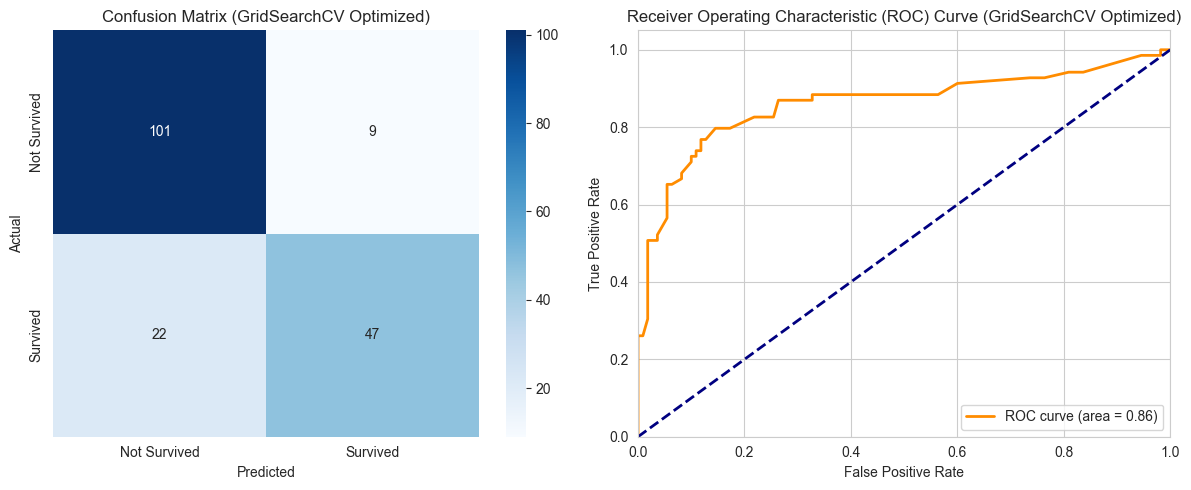

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_grid, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (GridSearchCV Optimized)')

plt.subplot(1, 2, 2)
plt.plot(fpr_grid, tpr_grid, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_grid:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (GridSearchCV Optimized)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [21]:
print("\n--- Hyperparameter Tuning: RandomizedSearchCV ---")
param_distributions = {
    'C': uniform(loc=0.001, scale=100), # Sample C uniformly between 0.001 and 100.001
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2']
}


--- Hyperparameter Tuning: RandomizedSearchCV ---


In [22]:
rand_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_distributions=param_distributions,
    n_iter=50, # Number of different combinations to try. Adjust based on computational budget.
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [23]:
rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024851B8C550>,
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'lbfgs']},
                   random_state=42, scoring='accuracy', verbose=1)

In [24]:
print("\nBest parameters found by RandomizedSearchCV:", rand_search.best_params_)
print("Best cross-validation accuracy found by RandomizedSearchCV:", rand_search.best_score_)


Best parameters found by RandomizedSearchCV: {'C': 2.5429126744095187, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy found by RandomizedSearchCV: 0.8272825765783512


In [25]:
best_rand_model = rand_search.best_estimator_

In [26]:
y_pred_rand = best_rand_model.predict(X_test)
accuracy_rand = accuracy_score(y_test, y_pred_rand)
conf_matrix_rand = confusion_matrix(y_test, y_pred_rand)
class_report_rand = classification_report(y_test, y_pred_rand)
y_pred_proba_rand = best_rand_model.predict_proba(X_test)[:, 1]
fpr_rand, tpr_rand, _ = roc_curve(y_test, y_pred_proba_rand)
roc_auc_rand = auc(fpr_rand, tpr_rand)

print(f"\nAccuracy on Test Set (RandomizedSearchCV): {accuracy_rand:.4f}")
print("\nConfusion Matrix (RandomizedSearchCV):")
print(conf_matrix_rand)
print("\nClassification Report (RandomizedSearchCV):")
print(class_report_rand)
print(f"AUC Score on Test Set (RandomizedSearchCV): {roc_auc_rand:.4f}")



Accuracy on Test Set (RandomizedSearchCV): 0.8324

Confusion Matrix (RandomizedSearchCV):
[[101   9]
 [ 21  48]]

Classification Report (RandomizedSearchCV):
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       110
           1       0.84      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

AUC Score on Test Set (RandomizedSearchCV): 0.8632


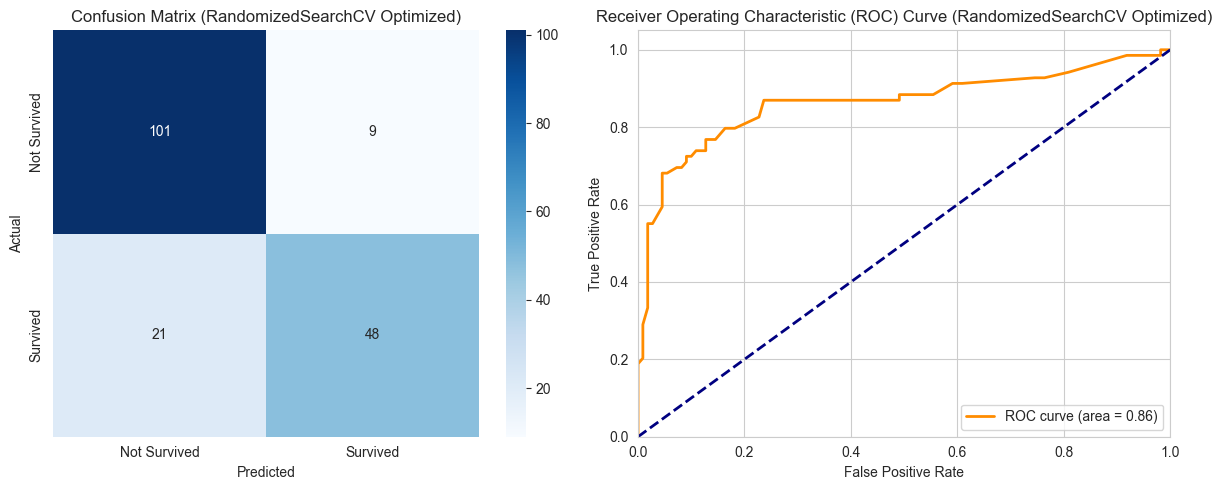

In [27]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_rand, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (RandomizedSearchCV Optimized)')

plt.subplot(1, 2, 2)
plt.plot(fpr_rand, tpr_rand, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rand:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (RandomizedSearchCV Optimized)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [29]:
print("\n--- Summary of Model Performance ---")
print(f"Baseline Model Accuracy:             {accuracy_baseline:.4f}")
print(f"GridSearchCV Optimized Model Accuracy: {accuracy_grid:.4f}")
print(f"RandomizedSearchCV Optimized Model Accuracy: {accuracy_rand:.4f}")

# You can also compare AUC scores similarly
print(f"Baseline Model AUC: {roc_auc_baseline:.4f}")
print(f"GridSearchCV Optimized Model AUC:    {roc_auc_grid:.4f}")
print(f"RandomizedSearchCV Optimized Model AUC: {roc_auc_rand:.4f}")


--- Summary of Model Performance ---
Baseline Model Accuracy:             0.8324
GridSearchCV Optimized Model Accuracy: 0.8268
RandomizedSearchCV Optimized Model Accuracy: 0.8324
Baseline Model AUC: 0.8636
GridSearchCV Optimized Model AUC:    0.8606
RandomizedSearchCV Optimized Model AUC: 0.8632
